In [82]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
SEED = 666
DATA_FILE = '../Datasets/cats/data/breeds_data_final.pkl'
IMAGES_DIR = '../Datasets/cats/images'
FIGURES_DIR = '../Figures/'
RESOLUTION = 64

In [3]:
data = pd.read_pickle(DATA_FILE)
# (Solved) PROBLEM: 26 unique breeds, but 66 included in final number of breeds, 
# lots of inaccuracy to account for here
#len(data['breed'].unique())

In [4]:
# Cats data string convertor
# Data was collected from Analysis/cats/cats_prediction_2.ipynb
age_list = ['Adult', 'Baby', 'Senior', 'Young']
gender_list = ['Female', 'Male']
size_list = ['Extra Large', 'Large', 'Medium', 'Small']
coat_list = ['Hairless', 'Long', 'Medium', 'Short']
breed_list = ['American Bobtail', 'American Shorthair', 'Bengal', 'Bombay',
        'Calico', 'Dilute Calico', 'Dilute Tortoiseshell',
        'Domestic Long Hair', 'Domestic Medium Hair',
        'Domestic Short Hair', 'Extra-Toes Cat - Hemingway Polydactyl',
        'Himalayan', 'Maine Coon', 'Manx', 'Persian', 'Ragdoll',
        'Russian Blue', 'Siamese', 'Snowshoe', 'Tabby', 'Tiger', 'Torbie',
        'Tortoiseshell', 'Turkish Angora', 'Turkish Van', 'Tuxedo']

#breed_list = np.empty(len(full_breed_list),dtype=object)
#for i in range(len(full_breed_list)):
#    if (i+1 in data['breed'].unique()):
#        breed_list[i] = full_breed_list[i]

#breed_list = breed_list[breed_list != None]
#print(breed_list)

def get_cat_string(cat, value):
    if(cat == 'age'):
        return age_list[int(value)]
    elif(cat == 'gender'):
        return gender_list[int(value)]
    elif(cat == 'size'):
        return size_list[int(value)]
    elif(cat == 'coat'):
        return coat_list[int(value)]
    elif(cat == 'breed'):
        return breed_list[int(value)]

# Prepare Data

In [5]:
# Images
import cv2
import random

random.seed(SEED)

In [135]:
def load_images(df):
    images = []
    for path in df['image']:
        img = load_img(os.path.join(IMAGES_DIR, path), target_size=(RESOLUTION, RESOLUTION))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img.astype(np.float32) / 255.0)
        #images.append(img)
    return np.vstack(images)

In [136]:
images = load_images(data)

In [122]:
# process data in cats_prediction_2
print(data.iloc[:, 4].shape)
print(images.shape)

(37794,)
(37794, 64, 64, 3)


3331 Adult Male Medium Short
914 Baby Female Large Short
11812 Adult Female Medium Short
3006 Baby Female Medium Short


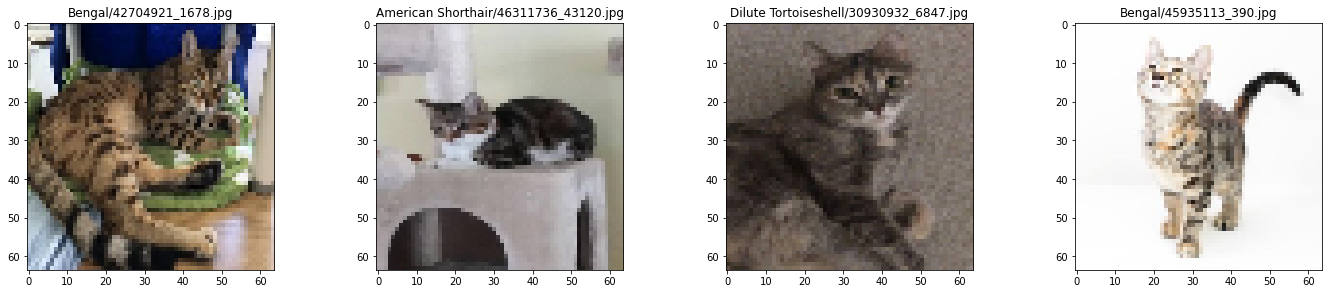

In [124]:
# I'm doubting if ML can determine a cat's gender... will test it using CNN
fig = plt.figure(figsize=(24, 10))
for i, r in enumerate([random.randint(0, images.shape[0]) for _ in range(4)]):
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(data.iloc[r, 5])
    ax.imshow(images[r])
    print(r, get_cat_string('age', data.iloc[r, 0]), get_cat_string('gender', data.iloc[r, 1]), get_cat_string('size', data.iloc[r, 2]), get_cat_string('coat', data.iloc[r, 3]))

# Network 1 - Basic CNN

In [12]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [138]:
# Breeds - [:, 4] are labels, images are X
X_train, X_test, y_train, y_test = train_test_split(images, data.iloc[:, 4], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(len(y_train), len(train_y.unique()))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

22676 26
(22676, 64, 64, 3) (22676,) (7559, 64, 64, 3) (7559,) (7559, 64, 64, 3) (7559,)


##  Test 1 - Simple CNN architecture
- The network is overfitting. Validation accuracy cannot escape from the local minima

In [ ]:
epochs = 50
#opt = optimizers.Adam(lr = 0.01)

In [172]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dense(len(breed_list), activation='softmax'))

model_1.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 11, 11, 128)     

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history_1 = model_1.fit(X_train, to_categorical(y_train), epochs=epochs, validation_data=(X_val, to_categorical(y_val)))

## Test 2 - Deeper network with augumented images
- The accuracy is climbing very slowly
- The validation accuracy stops at around 25-28%

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 3)))
model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(len(breed_list), activation='softmax'))

model_2.summary()

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [165]:
dg = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True)
dg.fit(X_train)

In [173]:
epochs = 50
#opt = optimizers.Adam(lr = 0.01)

model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history_2 = model_1.fit(dg.flow(X_train, to_categorical(y_train), batch_size=32), steps_per_epoch = len(X_train) / 32, epochs=epochs, validation_data=(X_val, to_categorical(y_val)))

Epoch 1/50
708/708 [==============================] - 97s 135ms/step - loss: 3.1222 - accuracy: 0.0954 - val_loss: 2.9444 - val_accuracy: 0.1314
Epoch 2/50
708/708 [==============================] - 97s 137ms/step - loss: 2.9357 - accuracy: 0.1354 - val_loss: 2.8723 - val_accuracy: 0.1462
Epoch 3/50
708/708 [==============================] - 97s 137ms/step - loss: 2.8536 - accuracy: 0.1571 - val_loss: 2.8186 - val_accuracy: 0.1647
Epoch 4/50
708/708 [==============================] - 98s 139ms/step - loss: 2.7968 - accuracy: 0.1783 - val_loss: 2.7810 - val_accuracy: 0.1770
Epoch 5/50
708/708 [==============================] - 98s 138ms/step - loss: 2.7572 - accuracy: 0.1825 - val_loss: 2.7256 - val_accuracy: 0.1941
Epoch 6/50
708/708 [==============================] - 97s 137ms/step - loss: 2.7145 - accuracy: 0.1946 - val_loss: 2.8088 - val_accuracy: 0.1799
Epoch 7/50
708/708 [==============================] - 97s 137ms/step - loss: 2.6693 - accuracy: 0.2101 - val_loss: 2.6786 - val_ac

# Exports

In [ ]:
import pickle

with open('../History/basic_CNN_epochs_'+str(epochs), 'wb') as file_pi:
        pickle.dump(history_1.history, file_pi)

In [ ]:
# Predict the values from the validation dataset
y_pred = model_1.predict(val_X)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#print(to_categorical(train_y).shape)
y_true = np.argmax(to_categorical(val_y),axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

In [ ]:
# print single prediction
# print(y_pred[0])
# plt.imshow(val_x[0])

In [ ]:
p = FIGURES_DIR+'basic_CNN/'
if not os.path.exists(p.rsplit('/',1)[0]):
    os.makedirs(p.rsplit('/',1)[0])

plt.plot(history_1.history['accuracy'], label='training data')
plt.plot(history_1.history['val_accuracy'], label='validation data')
t = 'Accuracy with '+str(epochs)+' Epochs'
plt.title(t)
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
name = p+'model_Accuracy_'+str(epochs)+'Epochs.png'
plt.savefig(name)
plt.show()

In [ ]:
import seaborn as sns
print(len(pd.unique(y_pred_classes)))

print(confusion_mtx)

br = pd.unique(y_pred_classes)

plt.figure(figsize=(20, 20))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
#c.set(xticklabels=br, yticklabels=br)
plt.savefig(p+'Basic_CNN_heatmap.png')

# Network 2 - Combine Net